<a href="https://colab.research.google.com/github/Pengchengzhi/Face-Alignment-DRF/blob/main/Procruses_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages

In [1]:
from google.colab import drive
drive.mount("/content/drive")

import os
path="/content/drive/My Drive/Face Alignment DRF"
os.chdir(path)
#os.listdir(path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import argparse, os, sys
import cv2
from PIL import Image
import json
import pandas as pd
import pdb
from scipy.spatial import procrustes
from sklearn.decomposition import PCA

dataset_helen_train_path="datasets/helen/trainset"
dataset_helen_test_path="datasets/helen/testset"

In [3]:
with open("datasets/cropped_helen/helen_cropped_train_pts.json",'r') as htrain:
  htrain_pts = json.load(htrain)
with open("datasets/cropped_helen/helen_cropped_test_pts.json",'r') as htest:
  htest_pts = json.load(htest)

# Original Faces

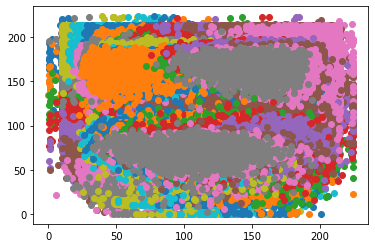

In [4]:
# plot face, same point same color
for i in range(68):
  x = [0]*2000
  y = [0]*2000
  j = 0
  for key in htrain_pts.keys():
    x[j] = htrain_pts[key][i][0]
    y[j] = 224-htrain_pts[key][i][1]
    j+=1
  plt.scatter(x,y)

Text(0.5, 1.0, 'Mean Face, Helen Dataset')

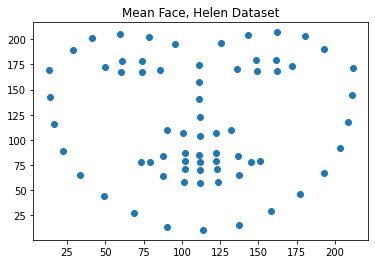

In [5]:
# mean shape
xbar = [0]*68
ybar = [0]*68
for i in range(68):
  x = 0
  y = 0
  j = 0
  for key in htrain_pts.keys():
    x += htrain_pts[key][i][0]
    y += htrain_pts[key][i][1]
    j+=1
  xbar[i] = x/2000
  ybar[i] = 224-y/2000
plt.scatter(xbar,ybar)
plt.title('Mean Face, Helen Dataset')

# Procustes Analysis

In [6]:
train_pts_arr = np.zeros((len(htrain_pts),68,2))
i = 0
for key in htrain_pts.keys():
  train_pts_arr[i,:,:] = np.array(htrain_pts[key])
  i+=1

In [7]:
alligned = train_pts_arr.copy()
x0 = train_pts_arr[0,:,:]
x1 = train_pts_arr[1,:,:]
m1,m2,_ = procrustes(x0,x1)
alligned[0,:,:] = m1
alligned[1,:,:] = m2
n_epochs = 200

align_err = np.zeros(n_epochs)
for epoch in range(n_epochs):

  # Allign all shape with x_0
  for i in range(1,len(htrain_pts)): # 1,2,3...1999
    _, alligned[i,:,:], err = procrustes(alligned[0,:,:],alligned[i,:,:])
    align_err[epoch]+=err

  # Calculate mean and allign mean with x_0
  mean = np.sum(alligned,axis=0)/len(htrain_pts)
  _, amean, _ = procrustes(m1,mean)

  # Allign all shape to the adjusted mean
  for i in range(1,len(htrain_pts)): # 1,2,3...1999
    b = alligned[i,:,:]
    _, alligned[i,:,:], _ = procrustes(amean,alligned[i,:,:])
    
  
  if (epoch+1)%20 == 0:
    print('Alligned', epoch+1, "rounds, Error now: ", align_err[epoch])

Alligned 20 rounds, Error now:  156.630574451508
Alligned 40 rounds, Error now:  156.63057445150804
Alligned 60 rounds, Error now:  156.63057445150807
Alligned 80 rounds, Error now:  156.63057445150798
Alligned 100 rounds, Error now:  156.630574451508
Alligned 120 rounds, Error now:  156.63057445150798
Alligned 140 rounds, Error now:  156.63057445150804
Alligned 160 rounds, Error now:  156.63057445150798
Alligned 180 rounds, Error now:  156.63057445150804
Alligned 200 rounds, Error now:  156.63057445150807


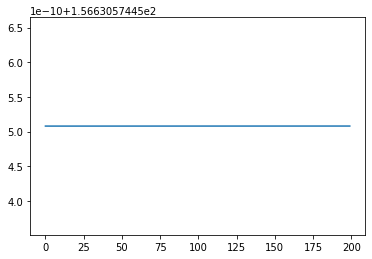

In [8]:
x = np.arange(n_epochs)
plt.plot(x,align_err)

# PCA

In [47]:
ndim = 20

In [48]:
data_pca = alligned.reshape(len(train_pts_arr),-1) #(2000, 136)
mean_shape = np.sum(data_pca,axis=0)/len(train_pts_arr)
pca = PCA(n_components=ndim)
pca.fit(data_pca)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

Text(0.5, 1.0, 'Mean shape before pca')

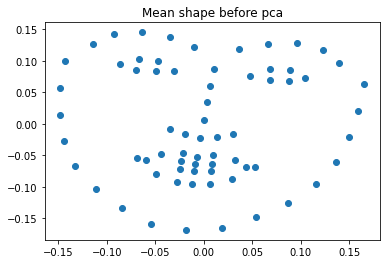

In [53]:
x = mean_shape[::2]
y = mean_shape[1::2]
plt.scatter(x,-y)
plt.title('Mean shape before pca')

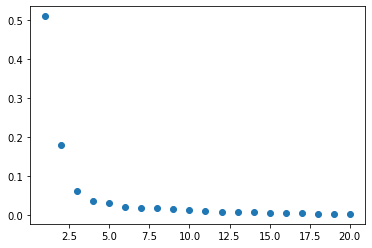

In [49]:
plt.scatter(np.arange(1,ndim+1), pca.explained_variance_ratio_)

In [50]:
np.sum(pca.explained_variance_ratio_)

0.9614543004059489

In [51]:
X_new = pca.transform(data_pca) # (2000, ndim)

Text(0.5, 1.0, 'First face after pca')

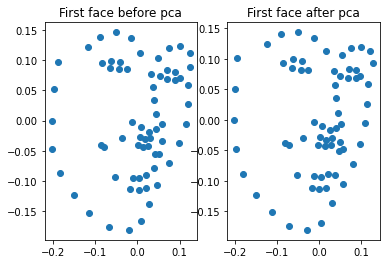

In [52]:
first = alligned[0,:,:].reshape(-1)
x = first[::2]
y = first[1::2]
plt.subplot(121)
plt.scatter(x,-y)
plt.title('First face before pca')

pca_face = mean_shape.copy()
for i in range(ndim):
  pca_face+=X_new[0,i]*pca.components_[i,:]

x = pca_face[::2]
y = pca_face[1::2]
plt.subplot(122)
plt.scatter(x,-y)
plt.title('First face after pca')

In [54]:
np.save("helen_train.npy",X_new)